In [ ]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def plot(array, title):
    plt.plot(array)
    plt.title(title)
    plt.show()

#importing image path
#image_path = "baby.jpg"
image_path = "Data/108.JPG"
#image_path = "bman.jpg"

imgColor = cv2.imread(image_path)

height, width, r = imgColor.shape

imgColor = cv2.cvtColor(imgColor, cv2.COLOR_BGR2RGB)

#calculating size of image to keep aspect ratio when resizing with desired height
ratio = height/width
newHeight = 700 #change according to resolution you want
newWidth = int(newHeight/ratio)
imgColor = cv2.resize(imgColor,(newWidth,newHeight),interpolation = cv2.INTER_CUBIC)

img = cv2.cvtColor(imgColor, cv2.COLOR_RGB2GRAY)
height, width = img.shape

# apply 15x15 Sobel filters to the intensity channel
I_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=15)
I_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=15)

I_m = cv2.magnitude(I_x, I_y)
thresh = .18

normIm = (I_m - I_m.min())/(I_m.max())

#creating binary image based off threshold
for row in range(0,height):
    for col in range(0,width):
        if(normIm[row,col] > thresh):
            normIm[row,col] = 0 #black
        else:
            normIm[row,col] = 255

#histogram init of vertical projection
heightHist = np.zeros((height,1), np.int)

#creating reagion we want a histogram of
lBox = int(width/4)
rBox = int(3*width/4)

#getting histogram based off of vertical projection
for row in range(0,height):
    for col in range(lBox,rBox):
        if(normIm[row,col] == 0): #if its black add +1
            heightHist[row] += 1


topBox = int(height/3)
botBox = int(3*height/5)

#most dense row based off histogram within eyeBox
lineIndex = -1

#going through general eye region to find most dense row
for row in range (topBox,botBox):
    if(heightHist[row,0]>heightHist[lineIndex,0]):
        lineIndex = row

#lines drawn to display results
cv2.line(imgColor, (0,lineIndex), (width-1,lineIndex), 0, 3) #horizontal line


#copy to invert for connectedComponents calculation
normInv = normIm.copy()
for row in range(0,height):
    for col in range(0,width):
        if(normIm[row,col]==0):
            normInv[row,col]=255
        else:
            normInv[row,col]=0

#cropping horizontaly from 'best fit' eyeline to create viable region to find both eyes
eyeBox = normInv[lineIndex-45:lineIndex+45,lBox:rBox]
#convert to unsigned Int between 0-255 to be able to use cv2.connectedComponents
eyeBox = np.uint8(eyeBox)
#getting markers, look it up


_,markers = cv2.connectedComponents(eyeBox)
#gives us number of dif connected regions
segNum = np.amax(markers)

#creates region for picking markers to detect left eye
leftEye = eyeBox[25:65,int(width/4)-80:int(width/4)-20]
leftEyeMarkers = markers[25:65,int(width/4)-80:int(width/4)-20]

#creates region for picking markers to detect right eye
rightEye = eyeBox[25:65,int(width/4)+40:int(width/4)+80]
rightEyeMarkers = markers[25:65,int(width/4)+40:int(width/4)+80]


#dictionaries to store connected components we are interested in
leyeSegNum = {}
reyeSegNum = {}

#add conneceted components into dictionaries, not adding region 0 (black)
for row in range(0,40):
    for col in range(0,40):
        if(leftEyeMarkers[row,col] not in leyeSegNum and leftEyeMarkers[row,col] != 0):
            leyeSegNum[leftEyeMarkers[row,col]] = 0
            
        if(rightEyeMarkers[row,col] not in reyeSegNum and rightEyeMarkers[row,col] != 0):
            reyeSegNum[rightEyeMarkers[row,col]] = 0
            
#computing full size of segments within a bigger box (full Eyebox)
for row in range(0,90):
    for col in range(0,int(width/2)):
        if(markers[row,col] in leyeSegNum):
            leyeSegNum[markers[row,col]] += 1
        if(markers[row,col] in reyeSegNum):
            reyeSegNum[markers[row,col]] += 1
            
#removing values under certain threshold in dic
lValueDic = {}
totalPixelsInL = 0
minRegion = 50 #PARAM
for item in leyeSegNum:
    if(leyeSegNum[item] >= minRegion):
        lValueDic[item] = leyeSegNum[item]
        totalPixelsInL += leyeSegNum[item]

rValueDic = {}
totalPixelsInR = 0
for item in reyeSegNum:
    if(reyeSegNum[item] > minRegion):
        rValueDic[item] = reyeSegNum[item]
        totalPixelsInR += reyeSegNum[item]
                               
#init left eye box constraints
#s stands for small & b stands for big, sX means small X coordinate/col meaning left side of the enclosing box
sXl = -1
sYl = -1
bXl = -1
bYl = -1

#init right eye box constraints
#s stands for small & b stands for big, sX means small X coordinate/col meaning left side of the enclosing box
sXr = -1
sYr = -1
bXr = -1
bYr = -1

#finding left, right, top, bottom eye box contrainsts
for row in range(0,90):
    for col in range(0, int(width/2)):
        if(markers[row,col] in lValueDic):
            if (row > bYl):
                bYl = row
            if (col > bXl):
                bXl = col
            if (row < sYl or sYl == -1):
                sYl = row
            if (col < sXl or sXl == -1):
                sXl = col
            eyeBox[row,col] = 190 #show segments we're putting in box as gray
        if(markers[row,col] in rValueDic):
            if (row > bYr):
                bYr = row
            if (col > bXr):
                bXr = col
            if (row < sYr or sYr == -1):
                sYr = row
            if (col < sXr or sXr == -1):
                sXr = col

#computing left eye width and height
wl = bXl - sXl
hl = bYl - sYl
#drawing left eye rectangle on eyeBox
cv2.rectangle(eyeBox, (sXl,sYl), (sXl+wl, sYl+hl), (150), 1)
#need to find coordinates with respect to full image
sXl = sXl + int(width/4)
bXl = bXl + int(width/4)
sYl = sYl + lineIndex - 45
bYl = bYl + lineIndex - 45
#drawing left eye rectangle on color image
cv2.rectangle(imgColor, (sXl,sYl), (sXl+wl, sYl+hl), (128,128,128), 3)

#computing right eye width and height
wr = bXr - sXr
hr = bYr - sYr
#drawing right eye rectangle on eyeBox
cv2.rectangle(eyeBox, (sXr,sYr), (sXr+wr, sYr+hr), (150), 1)
##need to find coordinates with respect to full image
sXr = sXr + int(width/4)
bXr = bXr + int(width/4)
sYr = sYr + lineIndex - 45
bYr = bYr + lineIndex - 45
#drawing right eye rectangle on color image
cv2.rectangle(imgColor, (sXr,sYr), (sXr+wr, sYr+hr), (128,128,128), 3)

cv2.line(imgColor, (int((sXr-bXl)/2) + bXl,0), (int((sXr-bXl)/2)+bXl,height-1), 0, 3) #vertical line

plt.figure(figsize=(10, 10))
plt.imshow(eyeBox, cmap ="gray")
plt.title("seg Image"), plt.xticks([]), plt.yticks([])
# plt.figure(figsize=(10, 10))
# plt.imshow(leftEye, cmap ="gray")
# plt.title("Left Eye Image"), plt.xticks([]), plt.yticks([])

print("left eye:")
print(sXl)
print(bXl)
print(sYl)
print(bYl)

print("right eye:")
print(sXr)
print(bXr)
print(sYr)
print(bYr)


# display images
plt.figure(figsize=(20, 20))

plt.subplot(121), plt.imshow(imgColor)
plt.title("Color Image"), plt.xticks([]), plt.yticks([]) #x&yticks determine the axis numbering
plt.subplot(122), plt.imshow(normIm, cmap="gray")
plt.title("Threshold Image"), plt.xticks([]), plt.yticks([])


plt.show()

In [ ]:
#Courtney your Viola-Jones code goes here...
#If you want to test your code with what I wrote lower down, just replace Xr, bXl, sXr, sXl, bYr, bYl, sYr, sYl
#with your updated values in this block and run the lower cells

#change based on where you downloaded opencv
#data_path = '/home/courtney/opencv-3.3.0/data/haarcascades/' #Courtney Path
#data_path = '/Applications/anaconda/share/OpenCV/haarcascades/' #Marcel Path
data_path = '/home/uday/anaconda3/share/OpenCV/haarcascades/' #Uday Path

#comes with opencv
face_cascade = cv2.CascadeClassifier(data_path + 'haarcascade_frontalface_default.xml')

#i downloaded these extra ones from github to try out
#opencv comes with 'haarcascade_eye.xml'
#opencv does not come with nose/mouth
eye_cascade = cv2.CascadeClassifier(data_path + 'haarcascade_eye.xml')
#mouth_cascade = cv2.CascadeClassifier(data_path + 'haarcascade_mcs_mouth.xml')

faces = face_cascade.detectMultiScale(img, 1.1, 2)

#display box to show located face in red
#calculate eye locations and display boxes in green
#calculate mouth location and display boxes in blue
#calculate nose location and display boxes in purple

#used for display
imgColorCopy = imgColor.copy()
faceCoords = [0,0,0,0]

#x,y,w,h are (x,y) of top left corner of face box and w,h of that box
for (x,y,w,h) in faces:
    faceCoords = [x,y,w,h]
    cv2.rectangle(imgColorCopy, (x,y), (x+w, y+h), (255,0,0), 2)
    
    #roi is face box and is used as new "image". 
    #All drawing, other than face, is done in respect to this box
    roi_gray = img[y:y+h, x:x+w]
    roi_color = imgColorCopy[y:y+h, x:x+w]
    
    #eyes
    eyes = eye_cascade.detectMultiScale(roi_gray, 1.1, 2)
    
    #best arrays will hold ex,ey,ew,eh which are (x,y) of top left corner of eye box and w,h of each of that box
    #left/rightDist will hold closest distance found to center line of face box (h/2)
    #left/rightHeight will hold closest distance found to eye line in respect to roi (lineIndex-y)
    bestLeftEye = [0,0,0,0]
    leftDist = -1
    leftHeight = -1
    bestRightEye = [0,0,0,0]
    rightDist = -1
    rightHeight = -1
    
    topBox = int(height/3)
    botBox = int(3*height/5)
    
    #ex,ey,ew,eh are (x,y) of top left corner of each eye box and w,h of respective box
    for (ex,ey,ew,eh) in eyes:
        if(ey < int(height/3) or ey > int(2*height/5)):
            #difference from center line of face box (w/2), to right line of eye box (ex+ew)
            ldiff = ((w/2)-(ex+ew))
            #difference from left line of eye box (ex), to center line of face box (w/2)
            rdiff = (ex-(w/2))
            #difference from bottom of eye box (ey+eh) to eye line in respect to roi (aka face box) (lineIndex-y) 
            hdiff = ((ey+eh) - (lineIndex-y))

            #choose optimal box that closest to center line but to the left and near eye line
            if(((ldiff < leftDist) or (leftDist == -1))  and (ldiff > 0)
              and ((hdiff < leftHeight) or (leftHeight == -1))  and (hdiff > 0)):
                leftDist = ldiff
                leftHeight = hdiff
                bestLeftEye = [ex,ey,ew,eh]

            #choose optimal box that closest to center line but to the right and near eye line
            if((( rdiff < rightDist) or (rightDist == -1)) and (rdiff > 0)
              and ((hdiff < rightHeight) or (rightHeight == -1))  and (hdiff > 0)):
                rightDist = rdiff
                rightHeight = hdiff
                bestRightEye = [ex,ey,ew,eh]
            
        #if you need to check, you can use these for all the possible boxes and points found
        #cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (0,255,255), 2)
        #cv2.circle(roi_color, (ex,ey), 2, (255,255,0), 2)
        
    #mouth
#     mouth = mouth_cascade.detectMultiScale(roi_gray, 1.1, 2)
    
#     #bestMouth will hold [mx,my,mw,mh] of mouth found to be best fit
#     #botDist will hold lowest difference beween bottom of mouth box and bottom of face box
#     bestMouth = [0,0,0,0]
#     botDist = -1
#     #doesn't seem to be necessary to do more computation but might want to check distance from center
# #     leftDist = -1
# #     rightDist = -1
#     #mx,my,mw,mh are (x,y) of top left corner of each mouth box and w,h of respective box
#     for (mx,my,mw,mh) in mouth:
#         #difference between bottom of face box (h) and bottom of mouth box (my+mh)
#         mdiff = (h-(my+mh))
        
#         #choose optimal box that is closest to bottom of face box region
#         if(((mdiff < botDist) or (botDist == -1)) and (my > 0)):
#             bestMouth = [mx,my,mw,mh]
#             botDist = mdiff
            
#         #if you need to check, you can use these for all the possible boxes and points found
#         #cv2.rectangle(roi_color, (mx,my), (mx+mw, my+mh), (0,0,255), 2)
#         #cv2.circle(roi_color, (mx,my+mh), 2, (255,255,0), 2)

#draw best fix rectangles
cv2.rectangle(roi_color, (bestLeftEye[0], bestLeftEye[1]), 
              (bestLeftEye[0]+bestLeftEye[2], bestLeftEye[1]+bestLeftEye[3]), (0,255,0), 2)
cv2.rectangle(roi_color, (bestRightEye[0], bestRightEye[1]), 
              (bestRightEye[0]+bestRightEye[2], bestRightEye[1]+bestRightEye[3]), (0,255,0), 2)
#cv2.rectangle(roi_color, (bestMouth[0], bestMouth[1]), 
              #(bestMouth[0]+bestMouth[2], bestMouth[1]+bestMouth[3]), (0,0,255), 2)

# display images
plt.figure(figsize=(15,15))
plt.imshow(imgColorCopy)
plt.title("Viola-Jones Image"), plt.xticks([]), plt.yticks([])
plt.show()

#set variables for next parts
wl = (bestLeftEye[2])
hl = (bestLeftEye[3])
sXl = (faceCoords[0] + bestLeftEye[0])
bXl = (faceCoords[0] + (bestLeftEye[0] + bestLeftEye[2]))
sYl = (faceCoords[1] + bestLeftEye[1])
bYl = (faceCoords[1] + (bestLeftEye[1] + bestLeftEye[3]))

wr = (bestRightEye[2])
hr = (bestRightEye[3])
sXr = (faceCoords[0] + bestRightEye[0])
bXr = (faceCoords[0] + (bestRightEye[0] + bestRightEye[2]))
sYr = (faceCoords[1] + bestRightEye[1])
bYr = (faceCoords[1] + (bestRightEye[1] + bestRightEye[2]))

print("Best Left Eye: " + str(bestLeftEye))

print("left eye:")
print(sXl)
print(bXl)
print(sYl)
print(bYl)

print(bestRightEye)
print("right eye:")
print(sXr)
print(bXr)
print(sYr)
print(bYr)

In [ ]:
#Need to create mouth and nose searching region 
#I am using: bXr, bXl, sXr, sXl, bYr, bYl, sYr, sYl
#Make sure cell above has these following variable available to use.

#copying image so that drawn components dont stay after re-running cell, *ALWAYS copy image in NEW CELL*
imgColor2 = imgColor.copy()
#Deyes is the length of outer eye boxes (left of lefteye -> right of righteye)
Deyes = bXr - sXl
print(Deyes)
#making sure Deyes is even as we will be dividing by 2 and dont want to round
if(Deyes % 2 == 1):
    Deyes = Deyes -1 
#middle of the eyes isnt necessarily width/2... (left of righteye - right of lefteye)    
#midEyes isnt the distance between both eyes but the col at which to draw the line on the original image
innerEyeDist = (sXr-bXl)
midEyes = bXl + int(innerEyeDist/2)

#Finding the lowest eye box, from this point our mouth & nose finding region will begin.
#Our upper mouth & nose region will be bounded by the lowest eye box
if(bYl > bYr):
    upperBound = bYl
else:
    upperBound = bYr

#lowerBound is just upperbound + Deyes
lowerBound = upperBound + Deyes
#left&rightBound are determined using eye centers and not image center
leftBound = midEyes - int(Deyes/2) #still need to cast to in as these will be used an indices
rightBound = midEyes + int(Deyes/2) 

print(leftBound)
print(rightBound)

#uncomment/comment if you want to see/hide where mouth & nose region is on the colored image
#cv2.rectangle(imgColor2, (leftBound,upperBound), (leftBound+Deyes, upperBound+Deyes), (0,255,0), 3)

#clipping out region we want to search
mouthNoseBox = normIm[upperBound:lowerBound,leftBound:rightBound]

print(mouthNoseBox.shape)

#need to project mounthNoseBox on vertical axis, same process as for the eyes...
#histogram init of vertical projection
mouthNoseHist = np.zeros((Deyes,1), np.float32)

#getting histogram based off of vertical projection
for row in range(0,Deyes):
    for col in range(0,Deyes):
        if(row >= mouthNoseBox.shape[0]):
            break
        if(col >= mouthNoseBox.shape[1]):
            break
        if(mouthNoseBox[row,col] == 0): #if its black add +1
            mouthNoseHist[row] += 1

#uncomment/comment if you want to see/hide histogram
#plot(mouthNoseHist,"mouthNoseHist")


#need to apply an average filter of width 29 to mouthNoseHist
mouthNoseHistpad = np.zeros((Deyes+29-1,1), np.float32)
mouthNoseHistpad[14:Deyes+14]=mouthNoseHist
for x in range(0,Deyes):
    mouthNoseHist[x] = int(sum(mouthNoseHistpad[x:x+29])/29)

#uncomment/comment if you want to see/hide averaged/smoothed histogram
plot(mouthNoseHist,"mouthNoseHist AVERAGED")


#need to locate the two top peaks as those will be the location of the nose and mouth
#calculate derivative and find zero crossing
firstDrv = np.zeros((Deyes,1),np.float32)
for x in range(0,Deyes):
    if(x == 0):
        firstDrv[x] = (mouthNoseHist[x] -mouthNoseHist[x])
    else:
        firstDrv[x] = (mouthNoseHist[x] -mouthNoseHist[x-1])

#uncomment/comment if you want to see/hide First Derivative of averaged mouthNoseHist
plot(firstDrv, "First Derivative")


#keep this commented OUT, bad idea to smooth the first derivative curve... Gives you less accurate zerocrossings...
# firstDrvHist = np.zeros((Deyes+5-1,1), np.float32)
# firstDrvHist[2:Deyes+2]=firstDrv
# for x in range(0,Deyes):
#     firstDrv[x] = int(sum(firstDrvHist[x:x+5])/5)

#init nose & mouth lines
noseLine = -1
mouthLine = -1

#assumes that our first derivative will go up at first, pos is set to TRUE
if(firstDrv[0] >= 0):
    pos = True  #this variable will keep track of whether we are positive or negative
                #When we encounter a negative value and pos is TRUE then we know we crossed a zero

#need to store all good zero crossings and then find top two...
#create a dictionary where the 'key' is the row at which the zero crossing takes place, 
#the 'value' is the histogram value at that row 
zeroCrossDic = {}

#Checking for zero crossings in our first derivative graph
#WE ONLY WANT positive to negative zero crossing as those indicate relative maximums
for x in range (1,Deyes):
    if(firstDrv[x] < 0 and pos):
        pos = False
        print("pos -> neg zero Cross: ",x)
        zeroCrossDic[x] = mouthNoseHist[x,0]
    else:
        if(firstDrv[x] > 0 and pos==False):
            pos = True
            print("neg -> pos zero Cross (not what we want): ",x)

topVal1 = [-1,0] #first zero crossing: [0] contains the peak value, [1] contains the index(row) it happens at
topVal2 = [-1,0]

#looking for zero crossing with highest histogram value and store it in topVal1
for item in zeroCrossDic:
    if(zeroCrossDic[item] > topVal1[0]):
        topVal1[0] = zeroCrossDic[item]
        topVal1[1] = item

#looking for zero crossing with 2nd highest histogram value and store it in topVal2      
for item in zeroCrossDic:
    if(zeroCrossDic[item] > topVal2[0] and zeroCrossDic[item] != topVal1[0]):
        topVal2[0] = zeroCrossDic[item]
        topVal2[1] = item
    
#of topVal1 & topVal2, look at their second index [1] which represents the row they occur at
#the one that occurs at a lower numbered row must be the nose, and the other the mouth
if(topVal1[1] < topVal2[1]):
    noseLine = topVal1[1] + upperBound
    mouthLine = topVal2[1] + upperBound
else:
    mouthLine = topVal1[1] + upperBound
    noseLine = topVal2[1] + upperBound
    
#NOTE can print zeroCrossDic for debugging
#print(zeroCrossDic)
    
#drawing corresponding lines at mouthLine and noseLine row values   
cv2.line(imgColor2, (0,noseLine), (width-1,noseLine), 0, 3) #horizontal line
cv2.line(imgColor2, (0,mouthLine), (width-1,mouthLine), 0, 3) #horizontal line


plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(mouthNoseBox, cmap ="gray")
plt.title("mouthNose Box"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgColor2)
plt.title("Color Image"), plt.xticks([]), plt.yticks([])

plt.show()

In [ ]:
#now that mouth line is found use region labeling to find mouth box and display it 
#I am just using mouthLine to find mouth region

#copy imgColor2 as I am in different cell
imgColor3 = imgColor2.copy()
mBoxHalf = int(Deyes/2) #I know Deyes is even, but still need to cast as mBaxHalf will be an index

#cropping from mouthLine to get region that totally encapsullates mouth (ok if bigger than mouth)
fullMouthBox = normInv[mouthLine-50:mouthLine+50,int(width/2)-mBoxHalf:int(width/2)+mBoxHalf]
#convert to unsigned Int between 0-255 to be able to use cv2.connectedComponents
fullMouthBox = np.uint8(fullMouthBox)
#getting markers, look it up
_,mouthMarkers = cv2.connectedComponents(fullMouthBox)

#gives us number of dif connected regions
mouthSegments = np.amax(mouthMarkers)

#creates region for picking markers to detect rmouth
#how well will these hardcoded regions work? can change these to detect more or less of the mouth
#PARAM
mouth = fullMouthBox[20:80,mBoxHalf-20:mBoxHalf+20]
mouthM = mouthMarkers[20:80,mBoxHalf-20:mBoxHalf+20]


#dictionaries to store connected components we are interested in
mouthSegNum = {}


#add conneceted components into dictionaries, not adding region 0 (black)
for row in range(0,60):
    for col in range(0,40):
        if(mouthM[row,col] not in mouthSegNum and mouthM[row,col] != 0):
            mouthSegNum[mouthM[row,col]] = 0

            
#computing full size of segments within a bigger box (fullMouthBox)
for row in range(0,100):
    for col in range(0,2*mBoxHalf):
        if(mouthMarkers[row,col] in mouthSegNum):
            mouthSegNum[mouthMarkers[row,col]] += 1

            
#removing values under certain threshold in dic
mouthValueDic = {}
totalPixelsInM = 0
minRegion = 20 #PARAM
for item in mouthSegNum:
    if(mouthSegNum[item] >= minRegion):
        mouthValueDic[item] = mouthSegNum[item]
        totalPixelsInM += mouthSegNum[item]

#init mouth box constraints: small & big: Xm & Ym
#s stands for small & b stands for big, sX means small X coordinate/col meaning left side of the enclosing box
sXm = -1
sYm = -1
bXm = -1
bYm = -1

#finding left, right, top, bottom mouth box contrainsts
for row in range(0,100):
    for col in range(0,2*mBoxHalf):
        if(mouthMarkers[row,col] in mouthValueDic):
            if (row > bYm):
                bYm = row
            if (col > bXm):
                bXm = col
            if (row < sYm or sYm == -1):
                sYm = row
            if (col < sXm or sXm == -1):
                sXm = col
            fullMouthBox[row,col] = 190 #show segments we're putting in box as gray
            
#computing mouth width and height
wm = bXm - sXm
hm = bYm - sYm
#drawing mouth rectangle on eyeBox
cv2.rectangle(fullMouthBox, (sXm,sYm), (sXm+wm, sYm+hm), (150), 1)

#need to find coordinates with respect to full image
sXm = sXm + int(width/2) - mBoxHalf
bXm = bXm + int(width/2) - mBoxHalf
sYm = sYm + mouthLine - 50
bYm = bYm + mouthLine - 50
#drawing mouth rectangle on color image
cv2.rectangle(imgColor3, (sXm,sYm), (sXm+wm, sYm+hm), (128,128,128), 3)

plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(fullMouthBox, cmap ="gray")
plt.title("fullMouthBox which containts the drawn mouth box"), plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(imgColor3)
plt.title("Color3 Image"), plt.xticks([]), plt.yticks([]) #x&yticks determine the axis numbering



plt.show()

## Stage 2 - *Feature extraction*
##### Variables to use for feature extraction from the previous cells above are as follows: 
##### Mouth: mouthLine(mouth row location), sXm, bXm, sYm, bYm(each gives you box sides), wm(width), hm(height)
##### Nose: noseLine(nose row location), midEyes(nose col location, should be close to width/2 if image is centered)
##### Eyes: lineIndex (gives you line crossing both eyes), Deyes (distance between outer part of both eyes),
##### LeftEye: sXl, bXl, sYl, bYl(each gives you box sides), wl(width), hl(height)
##### RightEye: sXr, bXr, sYr, bYr(each gives you box sides), wr(width), hr(height)

In [ ]:
#Wrinkle features

#Load image
imgColor = cv2.imread(image_path)
imgColor = cv2.cvtColor(imgColor, cv2.COLOR_BGR2RGB)

#calculating size of image to keep aspect ratio when resizing with desired height
ratio = height/width
newHeight = 700 #change according to resolution you want
newWidth = int(newHeight/ratio)
imgColor = cv2.resize(imgColor,(newWidth,newHeight),interpolation = cv2.INTER_CUBIC)
imgFeatureBox = imgColor.copy()

#Coordinates (smallX, bigX, smallY, bigY)
leftCheek = [sXl, sXm, bYl, sYm]
rightCheek = [bXm, bXr, bYr, sYm]
leftCrow = [int(sXl - ((bYl-sYl )/2)),sXl, sYl, bYl]
rightCrow = [bXr, int(bXr + ((bYr-sYr )/2)), sYr, bYr]
forehead = [sXl + int(wl/2) , sXr + int(wl/2), sYl-int(1.5*hl), sYr-int(0.5*hl)]

print(hl)
print("X1: " + str(forehead[0]) + " X2: " + str(forehead[1]))
print("Y1: " + str(forehead[2]) + " Y2: " + str(forehead[3]))

#Draw bounding boxes for each wrinkle area
cv2.rectangle(imgColor, (leftCheek[0], leftCheek[2]), (leftCheek[1], leftCheek[3]), (128,128,128), 3)
cv2.rectangle(imgColor, (rightCheek[0], rightCheek[2]), (rightCheek[1], rightCheek[3]), (128,128,128), 3)
cv2.rectangle(imgColor, (leftCrow[0], leftCrow[2]), (leftCrow[1], leftCrow[3]), (128,128,128), 3)
cv2.rectangle(imgColor, (rightCrow[0], rightCrow[2]), (rightCrow[1], rightCrow[3]), (128,128,128), 3)
cv2.rectangle(imgColor, (forehead[0], forehead[2]), (forehead[1], forehead[3]), (128,128,128), 3)
#Display wrinkle areas
plt.imshow(imgColor)
plt.title("Color3 Image"), plt.xticks([]), plt.yticks([])
plt.show()

#Crop each wrinkle area
leftCheek = imgFeatureBox[leftCheek[2]:leftCheek[3], leftCheek[0]:leftCheek[1]]
rightCheek = imgFeatureBox[rightCheek[2]:rightCheek[3], rightCheek[0]:rightCheek[1]]
leftCrow = imgFeatureBox[leftCrow[2]:leftCrow[3], leftCrow[0]:leftCrow[1]]
rightCrow = imgFeatureBox[rightCrow[2]:rightCrow[3], rightCrow[0]:rightCrow[1]]
forehead = imgFeatureBox[forehead[2]:forehead[3], forehead[0]:forehead[1]]

plt.imshow(forehead)
plt.title("Color3 Image"), plt.xticks([]), plt.yticks([])
plt.show()

#Create sobel filters
sobelx = np.array([[-1,0,1],
                   [-2,0,2],
                   [-1,0,1]])
sobely = np.array([[-1,-2,-1],
                   [0,0,0],
                   [1,2,1]])

def computeSobelEdge(img):
    #-------Compute Image derivatives-------
    height, width = img.shape
    #create blank canvas with a 1 pixel border on each side
    canvas = np.zeros((height+2, width+2), np.float32)
    #place the image into the blank canvas
    canvas[1:height+1, 1:width+1] = img
    #create blank images for x and y sobel filters
    img_sx = np.zeros((height, width), np.float32)
    img_sy = np.zeros((height, width), np.float32)

    for row in range(0, height):
        for col in range(0, width):
            #3x3 area in canvas to convolute with the filter
            scanx = canvas[row:row+3, col:col+3]
            scany = canvas[row:row+3, col:col+3]
            #apply filters to area
            convx = sobelx*scanx
            convy = sobely*scany
            #the value of the center pixel is the sum of all convoluted pixels in the 3x3 area
            img_sx[row,col] = convx.sum() #x sobel image
            img_sy[row,col] = convy.sum() #y sobel image

    #-------Get Magnitude-------
    tempx = img_sx*img_sx
    tempy = img_sy*img_sy
    img_mag = np.sqrt(tempx+tempy)
    
    #plt.imshow(img_mag, cmap='gray')
    #plt.xticks([]), plt.yticks([])
    #plt.show()
    return img_mag

def getWrinkleCount(img):
    wrinkleCount = 0
    height, width = img.shape
    for row in range(0, height):
        for col in range(0, width):
            if img[row, col] > 40:
                wrinkleCount += 1
    return wrinkleCount

def getWrinkleDensity(img):
    height, width = img.shape
    
    wrinkleCount = getWrinkleCount(img)
    totalArea = height*width
    wrinkleDensity = np.absolute(wrinkleCount)/np.absolute(totalArea)
    return wrinkleDensity

def getWrinkleMagnitude(img):
    height, width = img.shape
    totalMagnitude = 0
    for row in range(0, height):
        for col in range(0, width):
            if img[row, col] > 40:
                totalMagnitude += img[row, col]
    return totalMagnitude

def getWrinkleDepth(img):
    totalWrinkleMagnitude = getWrinkleMagnitude(img)
    numberWrinkles = getWrinkleCount(img)
    wrinkleDepth = np.absolute(totalWrinkleMagnitude)/(255 * np.absolute(numberWrinkles))
    return wrinkleDepth

def getSkinVariance(img):
    height, width = img.shape
    totalWrinkleMagnitude = getWrinkleMagnitude(img)
    totalArea = height*width
    skinVariance = np.absolute(totalWrinkleMagnitude)/(255 * np.absolute(totalArea))
    return skinVariance

#Grayscaled winkle areas
leftCheek_gray = cv2.cvtColor(leftCheek, cv2.COLOR_RGB2GRAY)
rightCheek_gray = cv2.cvtColor(rightCheek, cv2.COLOR_RGB2GRAY)
leftCrow_gray = cv2.cvtColor(leftCrow, cv2.COLOR_RGB2GRAY)
rightCrow_gray = cv2.cvtColor(rightCrow, cv2.COLOR_RGB2GRAY)
forehead_gray = cv2.cvtColor(forehead, cv2.COLOR_RGB2GRAY)

#Get sobel edge magnitude
leftCheek_sobel = computeSobelEdge(leftCheek_gray)
rightCheek_sobel = computeSobelEdge(rightCheek_gray)
leftCrow_sobel = computeSobelEdge(leftCrow_gray)
rightCrow_sobel = computeSobelEdge(rightCrow_gray)
forehead_sobel = computeSobelEdge(forehead_gray)

#Get wrinkle density
leftCheek_wDensity = getWrinkleDensity(leftCheek_sobel)
rightCheek_wDensity = getWrinkleDensity(rightCheek_sobel)
leftCrow_wDensity = getWrinkleDensity(leftCrow_sobel)
rightCrow_wDensity = getWrinkleDensity(rightCrow_sobel)
forehead_wDensity = getWrinkleDensity(forehead_sobel)

#Get wrinkle depth
leftCheek_wDepth = getWrinkleDepth(leftCheek_gray)
rightCheek_wDepth = getWrinkleDepth(rightCheek_gray)
leftCrow_wDepth = getWrinkleDepth(leftCrow_gray)
rightCrow_wDepth = getWrinkleDepth(rightCrow_gray)
forehead_wDepth = getWrinkleDepth(forehead_gray)

#Get average skin variance
leftCheek_sVariance = getSkinVariance(leftCheek_gray)
rightCheek_sVariance = getSkinVariance(rightCheek_gray)
leftCrow_sVariance = getSkinVariance(leftCrow_gray)
rightCrow_sVariance = getSkinVariance(rightCrow_gray)
forehead_sVariance = getSkinVariance(forehead_gray)

In [ ]:
#Geometric features here

#R_em = D_em/D_ee (For babies will be smaller)
#D_em: distance between the eyes and the mouth
#D_ee: distance between two eyes’ centers
D_em = mouthLine - lineIndex

leftEyeXCenter = sXl + int((bXl-sXl)/2)
leftEyeYCenter = sYl + int((bYl-sYl)/2)
leftEyeCenter = (leftEyeXCenter,leftEyeYCenter)

rightEyeXCenter = sXr + int((bXr-sXr)/2)
rightEyeYCenter = sYr + int((bYr-sYr)/2)
rightEyeCenter = (rightEyeXCenter,rightEyeYCenter)

D_ee = math.sqrt( (leftEyeCenter[0]-rightEyeCenter[0])**2+(leftEyeCenter[1]-rightEyeCenter[1])**2 )
R_em = D_em/D_ee
print("R_em:", R_em)

#R_enm = D_en/D_nm (For babies will be close to or less than 1)
#D_en: distance between the eyes and the nose
#D_nm: distance between the nose and the mouth
D_nm = mouthLine - noseLine
D_en = noseLine - lineIndex
R_enm = D_en/D_nm 
print("R_enm:", R_enm)


In [35]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

#Create sobel filters
sobelx = np.array([[-1,0,1],
                   [-2,0,2],
                   [-1,0,1]])
sobely = np.array([[-1,-2,-1],
                   [0,0,0],
                   [1,2,1]])

def computeSobelEdge(img):
    #-------Compute Image derivatives-------
    height, width = img.shape
    #create blank canvas with a 1 pixel border on each side
    canvas = np.zeros((height+2, width+2), np.float32)
    #place the image into the blank canvas
    canvas[1:height+1, 1:width+1] = img
    #create blank images for x and y sobel filters
    img_sx = np.zeros((height, width), np.float32)
    img_sy = np.zeros((height, width), np.float32)

    for row in range(0, height):
        for col in range(0, width):
            #3x3 area in canvas to convolute with the filter
            scanx = canvas[row:row+3, col:col+3]
            scany = canvas[row:row+3, col:col+3]
            #apply filters to area
            convx = sobelx*scanx
            convy = sobely*scany
            #the value of the center pixel is the sum of all convoluted pixels in the 3x3 area
            img_sx[row,col] = convx.sum() #x sobel image
            img_sy[row,col] = convy.sum() #y sobel image

    #-------Get Magnitude-------
    tempx = img_sx*img_sx
    tempy = img_sy*img_sy
    img_mag = np.sqrt(tempx+tempy)

    return img_mag

def getWrinkleCount(img):
    wrinkleCount = 0
    height, width = img.shape
    for row in range(0, height):
        for col in range(0, width):
            if img[row, col] > 40:
                wrinkleCount += 1
    return wrinkleCount

def getWrinkleDensity(img):
    height, width = img.shape

    wrinkleCount = getWrinkleCount(img)
    totalArea = height*width
    wrinkleDensity = np.absolute(wrinkleCount)/np.absolute(totalArea)
    return wrinkleDensity

def getWrinkleMagnitude(img):
    height, width = img.shape
    totalMagnitude = 0
    for row in range(0, height):
        for col in range(0, width):
            if img[row, col] > 40:
                totalMagnitude += img[row, col]
    return totalMagnitude

def getWrinkleDepth(img):
    totalWrinkleMagnitude = getWrinkleMagnitude(img)
    numberWrinkles = getWrinkleCount(img)
    wrinkleDepth = np.absolute(totalWrinkleMagnitude)/(255 * np.absolute(numberWrinkles))
    return wrinkleDepth

def getSkinVariance(img):
    height, width = img.shape
    totalWrinkleMagnitude = getWrinkleMagnitude(img)
    totalArea = height*width
    skinVariance = np.absolute(totalWrinkleMagnitude)/(255 * np.absolute(totalArea))
    return skinVariance

def extractFeatures(image, filename):   
    
    imgColor = image

    height, width, r = imgColor.shape

    imgColor = cv2.cvtColor(imgColor, cv2.COLOR_BGR2RGB)

    #calculating size of image to keep aspect ratio when resizing with desired height
    ratio = height/width
    newHeight = 700 #change according to resolution you want
    newWidth = int(newHeight/ratio)
    imgColor = cv2.resize(imgColor,(newWidth,newHeight),interpolation = cv2.INTER_CUBIC)

    img = cv2.cvtColor(imgColor, cv2.COLOR_RGB2GRAY)
    height, width = img.shape

    # apply 15x15 Sobel filters to the intensity channel
    I_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=15)
    I_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=15)

    I_m = cv2.magnitude(I_x, I_y)
    thresh = .18

    normIm = (I_m - I_m.min())/(I_m.max())

    #creating binary image based off threshold
    for row in range(0,height):
        for col in range(0,width):
            if(normIm[row,col] > thresh):
                normIm[row,col] = 0 #black
            else:
                normIm[row,col] = 255

    #histogram init of vertical projection
    heightHist = np.zeros((height,1), np.int)

    #creating reagion we want a histogram of
    lBox = int(width/4)
    rBox = int(3*width/4)

    #getting histogram based off of vertical projection
    for row in range(0,height):
        for col in range(lBox,rBox):
            if(normIm[row,col] == 0): #if its black add +1
                heightHist[row] += 1


    topBox = int(height/3)
    botBox = int(3*height/5)

    #most dense row based off histogram within eyeBox
    lineIndex = -1

    #going through general eye region to find most dense row
    for row in range (topBox,botBox):
        if(heightHist[row,0]>heightHist[lineIndex,0]):
            lineIndex = row
            
    #copy to invert for connectedComponents calculation
    normInv = normIm.copy()
    for row in range(0,height):
        for col in range(0,width):
            if(normIm[row,col]==0):
                normInv[row,col]=255
            else:
                normInv[row,col]=0

    
    #change based on where you downloaded opencv
    #data_path = '/home/courtney/opencv-3.3.0/data/haarcascades/' #Courtney Path
    data_path = '/Applications/anaconda/share/OpenCV/haarcascades/'
    #data_path = '/Applications/anaconda/share/OpenCV/haarcascades/' #Marcel Path
    #data_path = '/home/uday/anaconda3/share/OpenCV/haarcascades/' #Uday Path

    #comes with opencv
    face_cascade = cv2.CascadeClassifier(data_path + 'haarcascade_frontalface_default.xml')

    #i downloaded these extra ones from github to try out
    #opencv comes with 'haarcascade_eye.xml'
    #opencv does not come with nose/mouth
    eye_cascade = cv2.CascadeClassifier(data_path + 'haarcascade_eye.xml')
    #mouth_cascade = cv2.CascadeClassifier(data_path + 'haarcascade_mcs_mouth.xml')

    faces = face_cascade.detectMultiScale(img, 1.1, 2)

    #display box to show located face in red
    #calculate eye locations and display boxes in green
    #calculate mouth location and display boxes in blue
    #calculate nose location and display boxes in purple

    #used for display
    imgColorCopy = imgColor.copy()
    faceCoords = [0,0,0,0]

    #x,y,w,h are (x,y) of top left corner of face box and w,h of that box
    for (x,y,w,h) in faces:
        faceCoords = [x,y,w,h]
        cv2.rectangle(imgColorCopy, (x,y), (x+w, y+h), (255,0,0), 2)

        #roi is face box and is used as new "image". 
        #All drawing, other than face, is done in respect to this box
        roi_gray = img[y:y+h, x:x+w]
        roi_color = imgColorCopy[y:y+h, x:x+w]

        #eyes
        eyes = eye_cascade.detectMultiScale(roi_gray, 1.1, 2)

        #best arrays will hold ex,ey,ew,eh which are (x,y) of top left corner of eye box and w,h of each of that box
        #left/rightDist will hold closest distance found to center line of face box (h/2)
        #left/rightHeight will hold closest distance found to eye line in respect to roi (lineIndex-y)
        bestLeftEye = [0,0,0,0]
        leftDist = -1
        leftHeight = -1
        bestRightEye = [0,0,0,0]
        rightDist = -1
        rightHeight = -1

        #ex,ey,ew,eh are (x,y) of top left corner of each eye box and w,h of respective box
        for (ex,ey,ew,eh) in eyes:
            #difference from center line of face box (w/2), to right line of eye box (ex+ew)
            ldiff = ((w/2)-(ex+ew))
            #difference from left line of eye box (ex), to center line of face box (w/2)
            rdiff = (ex-(w/2))
            #difference from bottom of eye box (ey+eh) to eye line in respect to roi (aka face box) (lineIndex-y) 
            hdiff = ((ey+eh) - (lineIndex-y))

            #choose optimal box that closest to center line but to the left and near eye line
            if(((ldiff < leftDist) or (leftDist == -1))  and (ldiff > 0)
              and ((hdiff < leftHeight) or (leftHeight == -1))  and (hdiff > 0)):
                leftDist = ldiff
                leftHeight = hdiff
                bestLeftEye = [ex,ey,ew,eh]

            #choose optimal box that closest to center line but to the right and near eye line
            if((( rdiff < rightDist) or (rightDist == -1)) and (rdiff > 0)
              and ((hdiff < rightHeight) or (rightHeight == -1))  and (hdiff > 0)):
                rightDist = rdiff
                rightHeight = hdiff
                bestRightEye = [ex,ey,ew,eh]

            #if you need to check, you can use these for all the possible boxes and points found
            #cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (0,255,255), 2)

    #draw best fix rectangles
    cv2.rectangle(roi_color, (bestLeftEye[0], bestLeftEye[1]), 
                  (bestLeftEye[0]+bestLeftEye[2], bestLeftEye[1]+bestLeftEye[3]), (255,255,0), 2)
    cv2.rectangle(roi_color, (bestRightEye[0], bestRightEye[1]), 
                  (bestRightEye[0]+bestRightEye[2], bestRightEye[1]+bestRightEye[3]), (255,255,0), 2)
    
    plt.imshow(cv2.cvtColor(roi_color, cv2.COLOR_BGR2RGB))
    plt.show()

    if(not filename.endswith(".png") and not filename.endswith(".jpg") and not filename.endswith(".JPG")):
        filename = filename + ".png"
    #display images
    cv2.imwrite("Output/" + filename, imgColorCopy)

    #set variables for next parts
    wl = (bestLeftEye[2])
    hl = (bestLeftEye[3])
    sXl = (faceCoords[0] + bestLeftEye[0])
    bXl = (faceCoords[0] + (bestLeftEye[0] + bestLeftEye[2]))
    sYl = (faceCoords[1] + bestLeftEye[1])
    bYl = (faceCoords[1] + (bestLeftEye[1] + bestLeftEye[3]))

    wr = (bestRightEye[2])
    hr = (bestRightEye[3])
    sXr = (faceCoords[0] + bestRightEye[0])
    bXr = (faceCoords[0] + (bestRightEye[0] + bestRightEye[2]))
    sYr = (faceCoords[1] + bestRightEye[1])
    bYr = (faceCoords[1] + (bestRightEye[1] + bestRightEye[2]))
    
    #Second cell

    #Need to create mouth and nose searching region 
    #I am using: bXr, bXl, sXr, sXl, bYr, bYl, sYr, sYl
    #Make sure cell above has these following variable available to use.

    #copying image so that drawn components dont stay after re-running cell, *ALWAYS copy image in NEW CELL*
    imgColor2 = imgColor.copy()
    #Deyes is the length of outer eye boxes (left of lefteye -> right of righteye)
    Deyes = bXr - sXl
    
    #making sure Deyes is even as we will be dividing by 2 and dont want to round
    if(Deyes % 2 == 1):
        Deyes = Deyes -1 
    #middle of the eyes isnt necessarily width/2... (left of righteye - right of lefteye)    
    #midEyes isnt the distance between both eyes but the col at which to draw the line on the original image
    innerEyeDist = (sXr-bXl)
    midEyes = bXl + int(innerEyeDist/2)

    #Finding the lowest eye box, from this point our mouth & nose finding region will begin.
    #Our upper mouth & nose region will be bounded by the lowest eye box
    if(bYl > bYr):
        upperBound = bYl
    else:
        upperBound = bYr

    #lowerBound is just upperbound + Deyes
    lowerBound = upperBound + Deyes
    #left&rightBound are determined using eye centers and not image center
    leftBound = midEyes - int(Deyes/2) #still need to cast to in as these will be used an indices
    rightBound = midEyes + int(Deyes/2) 

    #uncomment/comment if you want to see/hide where mouth & nose region is on the colored image
    #cv2.rectangle(imgColor2, (leftBound,upperBound), (leftBound+Deyes, upperBound+Deyes), (0,255,0), 3)

    #clipping out region we want to search
    mouthNoseBox = normIm[upperBound:lowerBound,leftBound:rightBound]

    #need to project mounthNoseBox on vertical axis, same process as for the eyes...
    #histogram init of vertical projection
    mouthNoseHist = np.zeros((Deyes,1), np.float32)

    #getting histogram based off of vertical projection
    for row in range(0,Deyes):
        for col in range(0,Deyes):
            if(row >= mouthNoseBox.shape[0]):
                break
            if(col >= mouthNoseBox.shape[1]):
                break
            if(mouthNoseBox[row,col] == 0): #if its black add +1
                mouthNoseHist[row] += 1


    #need to apply an average filter of width 29 to mouthNoseHist
    mouthNoseHistpad = np.zeros((Deyes+29-1,1), np.float32)
    mouthNoseHistpad[14:Deyes+14]=mouthNoseHist
    for x in range(0,Deyes):
        mouthNoseHist[x] = int(sum(mouthNoseHistpad[x:x+29])/29)

    #need to locate the two top peaks as those will be the location of the nose and mouth
    #calculate derivative and find zero crossing
    firstDrv = np.zeros((Deyes,1),np.float32)
    for x in range(0,Deyes):
        if(x == 0):
            firstDrv[x] = (mouthNoseHist[x] -mouthNoseHist[x])
        else:
            firstDrv[x] = (mouthNoseHist[x] -mouthNoseHist[x-1])

    #init nose & mouth lines
    noseLine = -1
    mouthLine = -1

    #assumes that our first derivative will go up at first, pos is set to TRUE
    if(firstDrv[0] >= 0):
        pos = True  #this variable will keep track of whether we are positive or negative
                    #When we encounter a negative value and pos is TRUE then we know we crossed a zero

    #need to store all good zero crossings and then find top two...
    #create a dictionary where the 'key' is the row at which the zero crossing takes place, 
    #the 'value' is the histogram value at that row 
    zeroCrossDic = {}

    #Checking for zero crossings in our first derivative graph
    #WE ONLY WANT positive to negative zero crossing as those indicate relative maximums
    for x in range (1,Deyes):
        if(firstDrv[x] < 0 and pos):
            pos = False
            zeroCrossDic[x] = mouthNoseHist[x,0]
        else:
            if(firstDrv[x] > 0 and pos==False):
                pos = True

    topVal1 = [-1,0] #first zero crossing: [0] contains the peak value, [1] contains the index(row) it happens at
    topVal2 = [-1,0]

    #looking for zero crossing with highest histogram value and store it in topVal1
    for item in zeroCrossDic:
        if(zeroCrossDic[item] > topVal1[0]):
            topVal1[0] = zeroCrossDic[item]
            topVal1[1] = item

    #looking for zero crossing with 2nd highest histogram value and store it in topVal2      
    for item in zeroCrossDic:
        if(zeroCrossDic[item] > topVal2[0] and zeroCrossDic[item] != topVal1[0]):
            topVal2[0] = zeroCrossDic[item]
            topVal2[1] = item

    #of topVal1 & topVal2, look at their second index [1] which represents the row they occur at
    #the one that occurs at a lower numbered row must be the nose, and the other the mouth
    if(topVal1[1] < topVal2[1]):
        noseLine = topVal1[1] + upperBound
        mouthLine = topVal2[1] + upperBound
    else:
        mouthLine = topVal1[1] + upperBound
        noseLine = topVal2[1] + upperBound

    #now that mouth line is found use region labeling to find mouth box and display it 
    #I am just using mouthLine to find mouth region

    #Third cell

    imgColor3 = imgColor2.copy()
    mBoxHalf = int(Deyes/2) #I know Deyes is even, but still need to cast as mBaxHalf will be an index

    #cropping from mouthLine to get region that totally encapsullates mouth (ok if bigger than mouth)
    fullMouthBox = normInv[mouthLine-50:mouthLine+50,int(width/2)-mBoxHalf:int(width/2)+mBoxHalf]
    #convert to unsigned Int between 0-255 to be able to use cv2.connectedComponents
    fullMouthBox = np.uint8(fullMouthBox)
    #getting markers, look it up
    _,mouthMarkers = cv2.connectedComponents(fullMouthBox)

    #gives us number of dif connected regions
    mouthSegments = np.amax(mouthMarkers)
    
    fullleftBound = 20
    fullrightBound = 80
    if(fullMouthBox.shape[0] < 60):
        fullleftBound = 0
        fullrightBound = fullMouthBox.shape[0]
    fullSize = fullrightBound - fullleftBound
        
    markleftBound = 20
    markrightBound = 80
    if(mouthMarkers.shape[0] < 60):
        markleftBound = 0
        markrightBound = mouthMarkers.shape[0]
    
    #creates region for picking markers to detect rmouth
    #how well will these hardcoded regions work? can change these to detect more or less of the mouth
    #PARAM
    mouth = fullMouthBox[fullleftBound:fullrightBound,mBoxHalf-20:mBoxHalf+20]
    mouthM = mouthMarkers[markleftBound:markrightBound,mBoxHalf-20:mBoxHalf+20]
    
    mouthMSizeY = mouthM.shape[0]
    mouthMSizeX = mouthM.shape[1]


    #dictionaries to store connected components we are interested in
    mouthSegNum = {}
    
    #add conneceted components into dictionaries, not adding region 0 (black)
    for row in range(0,mouthMSizeY):
        for col in range(0,mouthMSizeX):
            if(mouthM[row,col] not in mouthSegNum and mouthM[row,col] != 0):
                mouthSegNum[mouthM[row,col]] = 0

    #computing full size of segments within a bigger box (fullMouthBox)
    for row in range(0,100):
        for col in range(0,2*mBoxHalf):
            if(row >= mouthMarkers.shape[0]):
                break
            if(col >= mouthMarkers.shape[1]):
                break
            if(mouthMarkers[row,col] in mouthSegNum):
                mouthSegNum[mouthMarkers[row,col]] += 1


    #removing values under certain threshold in dic
    mouthValueDic = {}
    totalPixelsInM = 0
    minRegion = 20 #PARAM
    for item in mouthSegNum:
        if(mouthSegNum[item] >= minRegion):
            mouthValueDic[item] = mouthSegNum[item]
            totalPixelsInM += mouthSegNum[item]

    #init mouth box constraints: small & big: Xm & Ym
    #s stands for small & b stands for big, sX means small X coordinate/col meaning left side of the enclosing box
    sXm = -1
    sYm = -1
    bXm = -1
    bYm = -1

    #finding left, right, top, bottom mouth box contrainsts
    for row in range(0,100):
        for col in range(0,2*mBoxHalf):
            if(row >= mouthMarkers.shape[0]):
                break
            if(col >= mouthMarkers.shape[1]):
                break
            if(mouthMarkers[row,col] in mouthValueDic):
                if (row > bYm):
                    bYm = row
                if (col > bXm):
                    bXm = col
                if (row < sYm or sYm == -1):
                    sYm = row
                if (col < sXm or sXm == -1):
                    sXm = col
                fullMouthBox[row,col] = 190 #show segments we're putting in box as gray

    #computing mouth width and height
    wm = bXm - sXm
    hm = bYm - sYm

    #need to find coordinates with respect to full image
    sXm = sXm + int(width/2) - mBoxHalf
    bXm = bXm + int(width/2) - mBoxHalf
    sYm = sYm + mouthLine - 50
    bYm = bYm + mouthLine - 50

    #Fourth Cell

    #Wrinkle features

    imgFeatureBox = imgColor.copy()

    #Coordinates (smallX, bigX, smallY, bigY)
    leftCheek = [sXl, int(sXl+(0.75*(bXl-sXl))), bYl, sYm]
    rightCheek = [int(sXr+(0.25*(bXr-sXr))), bXr, bYr, sYm]
    leftCrow = [int(sXl - ((bYl-sYl )/2)),sXl, sYl, bYl]
    rightCrow = [bXr, int(bXr + ((bYr-sYr )/2)), sYr, bYr]
    forehead = [int(sXl + wl/2), int(sXr + wr/2), sYr - int(1.5*hl), sYr - int(0.5*hl)]

    #Draw bounding boxes for each wrinkle area
    cv2.rectangle(imgColor, (leftCheek[0], leftCheek[2]), (leftCheek[1], leftCheek[3]), (128,128,128), 3)
    cv2.rectangle(imgColor, (rightCheek[0], rightCheek[2]), (rightCheek[1], rightCheek[3]), (128,128,128), 3)
    cv2.rectangle(imgColor, (leftCrow[0], leftCrow[2]), (leftCrow[1], leftCrow[3]), (128,128,128), 3)
    cv2.rectangle(imgColor, (rightCrow[0], rightCrow[2]), (rightCrow[1], rightCrow[3]), (128,128,128), 3)
    cv2.rectangle(imgColor, (forehead[0], forehead[2]), (forehead[1], forehead[3]), (128,128,128), 3)
    #Display wrinkle areas
    #plt.imshow(imgColor)
    #plt.title("Color3 Image"), plt.xticks([]), plt.yticks([])
    #plt.show()

    #Crop each wrinkle area
    leftCheek = imgFeatureBox[leftCheek[2]:leftCheek[3], leftCheek[0]:leftCheek[1]]
    rightCheek = imgFeatureBox[rightCheek[2]:rightCheek[3], rightCheek[0]:rightCheek[1]]
    leftCrow = imgFeatureBox[leftCrow[2]:leftCrow[3], leftCrow[0]:leftCrow[1]]
    rightCrow = imgFeatureBox[rightCrow[2]:rightCrow[3], rightCrow[0]:rightCrow[1]]
    forehead = imgFeatureBox[forehead[2]:forehead[3], forehead[0]:forehead[1]]
    
    #Grayscaled winkle areas
    leftCheek_gray = cv2.cvtColor(leftCheek, cv2.COLOR_RGB2GRAY)
    rightCheek_gray = cv2.cvtColor(rightCheek, cv2.COLOR_RGB2GRAY)
    leftCrow_gray = cv2.cvtColor(leftCrow, cv2.COLOR_RGB2GRAY)
    rightCrow_gray = cv2.cvtColor(rightCrow, cv2.COLOR_RGB2GRAY)
    forehead_gray = cv2.cvtColor(forehead, cv2.COLOR_RGB2GRAY)
    
#     if(path == "Data/134.png"):

#         plt.imshow(leftCheek_gray, cmap="gray")
#         plt.show()

#         plt.imshow(rightCheek_gray, cmap="gray")
#         plt.show()

#         plt.imshow(leftCrow_gray, cmap="gray")
#         plt.show()

#         plt.imshow(rightCrow_gray, cmap="gray")
#         plt.show()

#         plt.imshow(forehead_gray, cmap="gray")
#         plt.show()
            
    featureBoxes = [leftCheek_gray, rightCheek_gray, leftCrow_gray, rightCrow_gray, forehead_gray]
    
    #print(featureBoxes)

    sobelFeatures = []
        
    #Get sobel edge magnitudes
    for i in range(len(featureBoxes)):
        try:
            sobelFeatures.append(computeSobelEdge(featureBoxes[i]))
        except AttributeError:
            print("Issue detecting features for: " + filename)
            sobelFeatures.append(None)
    
    finalFeatures = []
    
    #Get wrinkle features
    for i in range(len(sobelFeatures)):
        try:
            finalFeatures.append(getWrinkleDensity(sobelFeatures[i]))
        except AttributeError:
            finalFeatures.append(0)
        
        try:
            finalFeatures.append(getWrinkleDepth(sobelFeatures[i]))
        except AttributeError:
            finalFeatures.append(0)
            
        try:
            finalFeatures.append(getSkinVariance(sobelFeatures[i]))
        except AttributeError:
            finalFeatures.append(0)
        
    #Geometric features here

    #R_em = D_em/D_ee (For babies will be smaller)
    #D_em: distance between the eyes and the mouth
    #D_ee: distance between two eyes’ centers
    D_em = mouthLine - lineIndex

    leftEyeXCenter = sXl + int((bXl-sXl)/2)
    leftEyeYCenter = sYl + int((bYl-sYl)/2)
    leftEyeCenter = (leftEyeXCenter,leftEyeYCenter)

    rightEyeXCenter = sXr + int((bXr-sXr)/2)
    rightEyeYCenter = sYr + int((bYr-sYr)/2)
    rightEyeCenter = (rightEyeXCenter,rightEyeYCenter)

    D_ee = math.sqrt( (leftEyeCenter[0]-rightEyeCenter[0])**2+(leftEyeCenter[1]-rightEyeCenter[1])**2 )
    finalFeatures.append(D_em/D_ee)

    #R_enm = D_en/D_nm (For babies will be close to or less than 1)
    #D_en: distance between the eyes and the nose
    #D_nm: distance between the nose and the mouth
    D_nm = mouthLine - noseLine
    D_en = noseLine - lineIndex
    finalFeatures.append(D_en/D_nm)
        
    return finalFeatures

In [9]:
import csv

imageClassificationMap = {}

with open('imageLabels.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    count = 0
    for row in readCSV:
        if not (count == 0):
            imageClassificationMap[row[0]] = row[5]
        count += 1

In [10]:
import os
import random

fileNames = os.listdir("Data/")
fileNames.sort()
count = 0

features = []
targets = []

for fileName in fileNames:
    imageNumber = fileName.split('.')[0]
    ageGroup = ""
    labeledAge = int(float(imageClassificationMap[imageNumber]))
    if(labeledAge <= 2):
        ageGroup = "Baby"
    if(labeledAge >= 3 and labeledAge <= 39):
        ageGroup = "Young Adult"
    if(labeledAge >= 40 and labeledAge <= 59):
        ageGroup = "Middle-aged"
    if(labeledAge >= 60):
        ageGroup = "Old adult"
    try:
        image = cv2.imread(os.path.join("Data", fileName))
        features.append(extractFeatures(image, fileName))
        targets.append(ageGroup)
    except IndexError: 
        print("Unable to process image: " + fileName)

Issue detecting features for: 151.png
Issue detecting features for: 151.png
Issue detecting features for: 151.png
Issue detecting features for: 151.png


/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:590: RuntimeWarning: divide by zero encountered in long_scalars


Unable to process image: 156.png
Unable to process image: 168.png
Issue detecting features for: 207.jpg
Issue detecting features for: 207.jpg
Issue detecting features for: 207.jpg


ValueError: negative dimensions are not allowed

In [7]:
from sklearn import svm

Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.01, 0.1, 1, 10, 100]

bestResult = 0
bestC = 0
bestGamma = 0

for x in range(5):
    for j in range(5):
        ageClf = svm.SVC(gamma=gammas[j], C=Cs[x])
        ageClf.fit(features[:125], targets[:125])

        correctCount = 0
        totalCount = 0

        for i in range(126, len(features)):
            inputFeatures = np.asarray(features[i])
            inputFeatures = inputFeatures.reshape(1, -1)

            labeledAge = int(float(imageClassificationMap[str(i)]))
            ageGroup = ""
            if(labeledAge <= 2):
                ageGroup = "Baby"
            if(labeledAge >= 3 and labeledAge <= 39):
                ageGroup = "Young Adult"
            if(labeledAge >= 40 and labeledAge <= 59):
                ageGroup = "Middle-aged"
            if(labeledAge >= 60):
                ageGroup = "Old adult"


            if(ageClf.predict(inputFeatures) == ageGroup):
                correctCount += 1

            totalCount += 1
        
        if(correctCount/totalCount > bestResult):
            bestC = Cs[x]
            bestGamma = gammas[j]
            bestResult = correctCount/totalCount

print("Best SIFT C value: " + str(bestC))
print("Best SIFT gamma value: " + str(bestGamma))
print("")

bestN = 0
bestResult = 0

for x in range(64, 129):
    ageClf = RandomForestClassifier(n_estimators = x)
    ageClf.fit(features[:125], targets[:125])

    correctCount = 0
    totalCount = 0

    for i in range(126, len(features)):
        inputFeatures = np.asarray(features[i])
        inputFeatures = inputFeatures.reshape(1, -1)

        labeledAge = int(float(imageClassificationMap[str(i)]))
        ageGroup = ""
        if(labeledAge <= 2):
            ageGroup = "Baby"
        if(labeledAge >= 3 and labeledAge <= 39):
            ageGroup = "Young Adult"
        if(labeledAge >= 40 and labeledAge <= 59):
            ageGroup = "Middle-aged"
        if(labeledAge >= 60):
            ageGroup = "Old adult"


        if(ageClf.predict(inputFeatures) == ageGroup):
            correctCount += 1

        totalCount += 1

    if(correctCount/totalCount > bestResult):
        bestN = x
        bestResult = correctCount/totalCount
        
print("Best N estimators: " + str(bestN))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [72]:
ageClf = svm.SVC(gamma=0.01, C=10)
ageClf.fit(features[:125], targets[:125])

correctCount = 0
totalCount = 0

for i in range(126, len(features)):
    inputFeatures = np.asarray(features[i])
    inputFeatures = inputFeatures.reshape(1, -1)

    labeledAge = int(float(imageClassificationMap[str(i)]))
    ageGroup = ""
    if(labeledAge <= 2):
        ageGroup = "Baby"
    if(labeledAge >= 3 and labeledAge <= 39):
        ageGroup = "Young Adult"
    if(labeledAge >= 40 and labeledAge <= 59):
        ageGroup = "Middle-aged"
    if(labeledAge >= 60):
        ageGroup = "Old adult"


    if(ageClf.predict(inputFeatures) == ageGroup):
        correctCount += 1

    totalCount += 1
    
print(correctCount/totalCount)

ValueError: Expected 2D array, got 1D array instead:
array=[ 0.0384281   2.27675466  0.08749135  0.18168847  0.70524509  0.1281349
  0.09807956  1.38083194  0.13543139  0.1539283   1.08596369  0.16716054
  0.05327029  1.51980102  0.08096024  1.01657039  1.43877551].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [30]:
from sklearn.ensemble import RandomForestClassifier

ageClf = RandomForestClassifier(n_estimators = 66)
ageClf.fit(features[:125], targets[:125])

for i in range(126, len(features)):
    inputFeatures = np.asarray(features[i])
    inputFeatures = inputFeatures.reshape(1, -1)

    labeledAge = int(float(imageClassificationMap[str(i)]))
    ageGroup = ""
    if(labeledAge <= 2):
        ageGroup = "Baby"
    if(labeledAge >= 3 and labeledAge <= 39):
        ageGroup = "Young Adult"
    if(labeledAge >= 40 and labeledAge <= 59):
        ageGroup = "Middle-aged"
    if(labeledAge >= 60):
        ageGroup = "Old adult"


    if(ageClf.predict(inputFeatures) == ageGroup):
        correctCount += 1

    totalCount += 1
    
print(correctCount/totalCount)

0.5806451612903226


## Part 3: Age Tagging

[805 196 218 218]


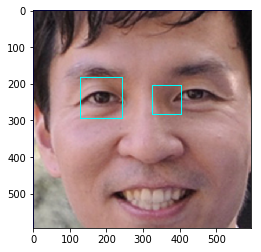

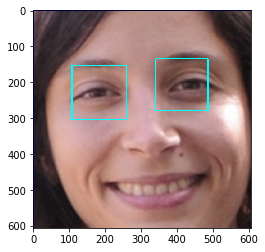

Issue detecting features for: Groups/group1.jpg


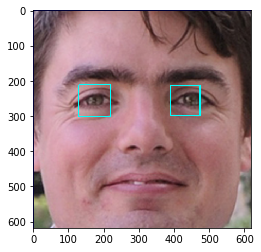

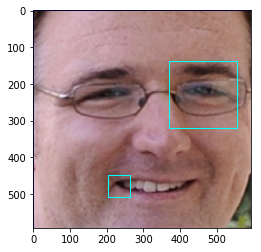

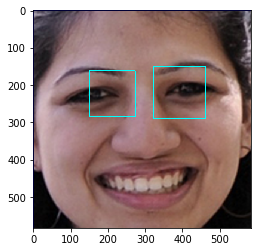

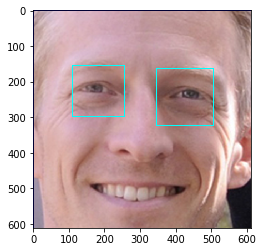

Issue detecting features for: Groups/group1.jpg


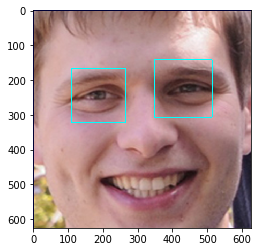

Issue detecting features for: Groups/group1.jpg


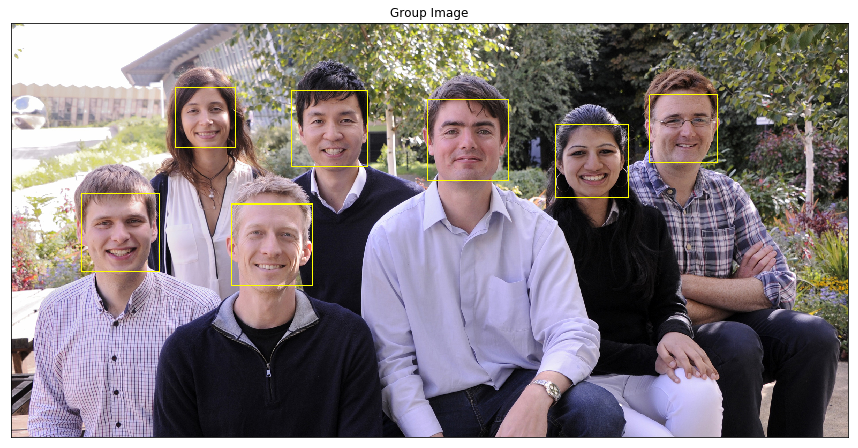

[753  42  85  85]


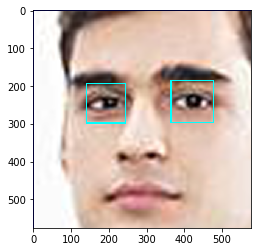

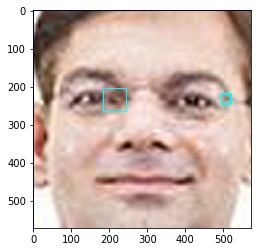

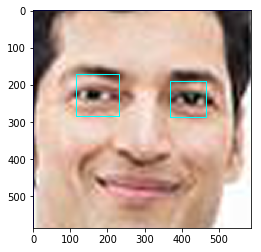

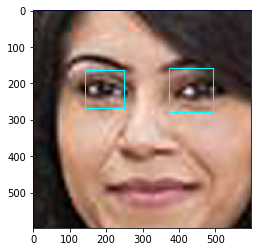

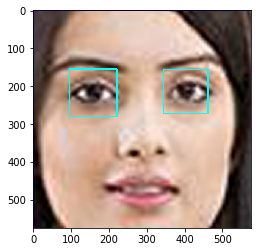

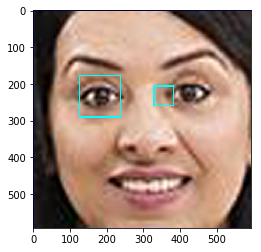

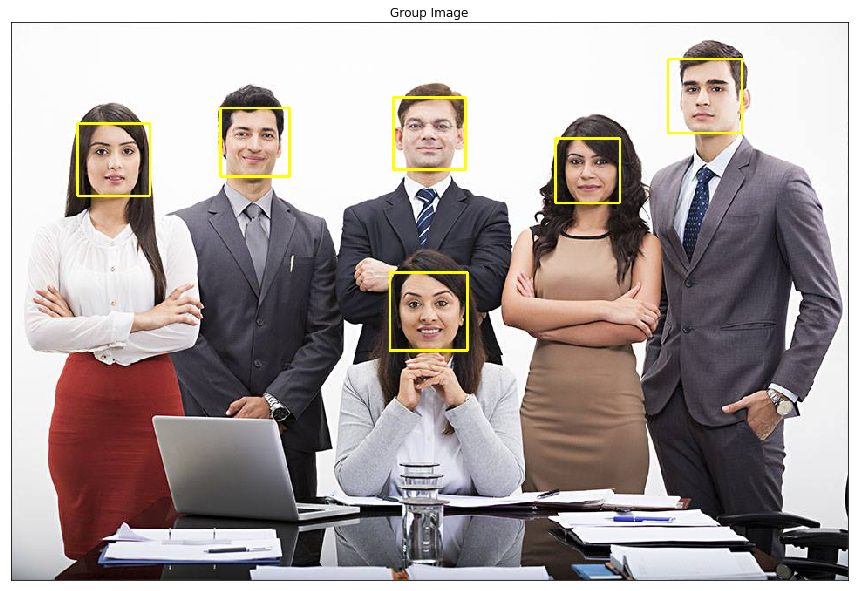

[562 103 158 158]


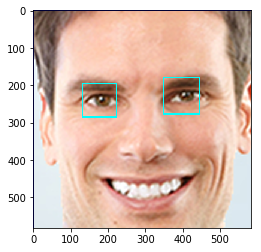

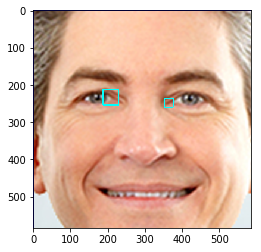

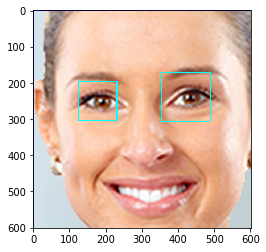

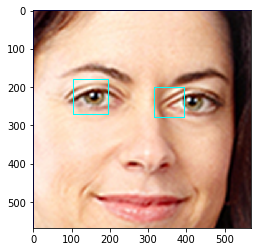

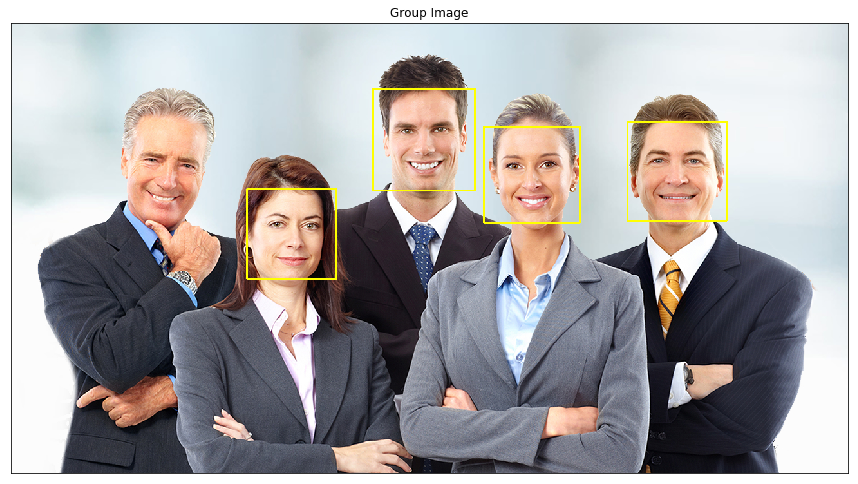

[598 338 746 746]


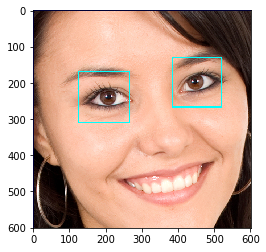

Issue detecting features for: Groups/group4.jpg


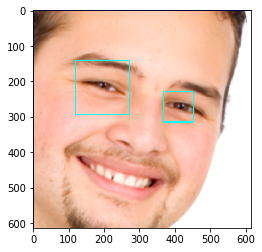

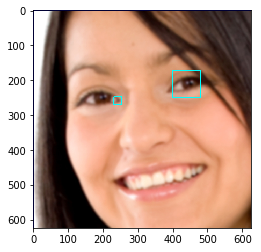

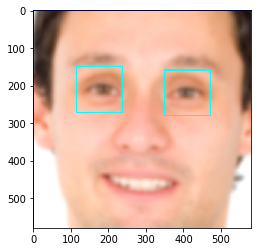

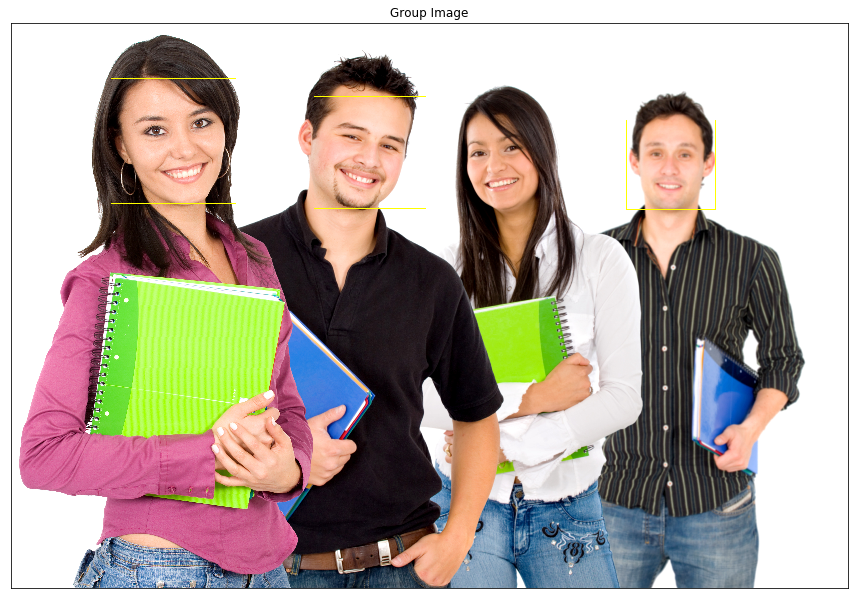

[150  87  50  50]


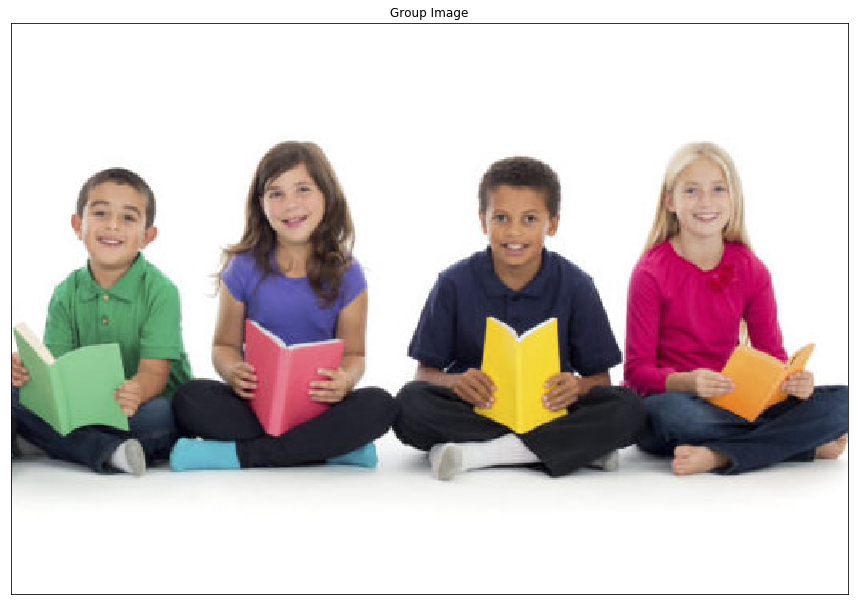

[361  45  66  66]


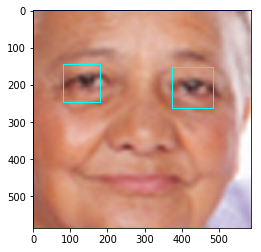

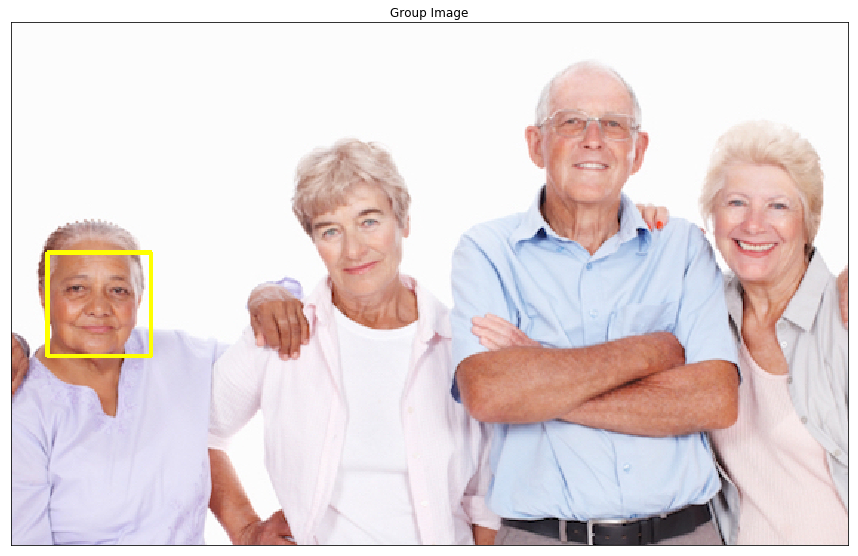

In [36]:
#used for display
# image_path = "group.jpg"
# imgGroup = cv2.imread(image_path)
# imgGroup = cv2.cvtColor(imgGroup, cv2.COLOR_BGR2RGB)
# imgGroupGray = cv2.cvtColor(imgGroup, cv2.COLOR_RGB2GRAY)

fileNames = os.listdir("Groups/")

ages1 = ["Young Adult", "Middle-aged", "Young Adult", "Young Adult", "Young Adult", "Young Adult"]

#change based on where you downloaded opencv
#data_path = '/home/courtney/opencv-3.3.0/data/haarcascades/'
data_path = '/Applications/anaconda/share/OpenCV/haarcascades/'
#data_path = '/home/uday/anaconda3/share/OpenCV/haarcascades/' #Uday Path

#comes with opencv
face_cascade = cv2.CascadeClassifier(data_path + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(data_path + 'haarcascade_eye.xml')

for fileName in fileNames:
    image_path = os.path.join("Groups", fileName)
    imgGroup = cv2.imread(image_path)
    imgGroup = cv2.cvtColor(imgGroup, cv2.COLOR_BGR2RGB)
    imgGroupGray = cv2.cvtColor(imgGroup, cv2.COLOR_RGB2GRAY)
    
    faces = face_cascade.detectMultiScale(imgGroupGray, 1.1, 10)
    print(faces[0])
    counter = 0
    for (x,y,w,h) in faces:
        roi_gray = imgGroupGray[y:y+h, x:x+w]
        roi_color = imgGroup[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray, 1.1, 2)

        if(len(eyes) > 1):
#             plt.imshow(roi_color)
#             plt.show()
            cv2.rectangle(imgGroup, (x,y), (x+w, y+h), (255,255,0), 2)
            features = extractFeatures(roi_color, image_path)
            inputFeatures = np.asarray(features).reshape(1, -1)
#             age = ageClf.predict(inputFeatures)
#             if(ages1[counter] == age):
#                 cv2.rectangle(imgGroup, (x,y), (x+w, y+h), (0,255,0), 2)
#             else:
#                 cv2.rectangle(imgGroup, (x,y), (x+w, y+h), (255,0,0), 2)
       
#             cv2.putText(imgGroup, age, (x,y), cv2.FONT_HERSHEY_DUPLEX)


    # display images
    plt.figure(figsize=(15,15))
    plt.imshow(imgGroup)
    plt.title("Group Image"), plt.xticks([]), plt.yticks([])
    plt.show()